# Multi-frame Ribo-seq and mRNA-seq visualization

Author: Charles E. Vejnar (charles.vejnar@gmail.com) (Original plot design from [Timothy Johnstone](https://github.com/tgjohnst))

This notebook demonstrates how to plot Ribo-seq and mRNA-seq transcript profiles represented as read-coverage. To visualize how much each Open Reading Frame (ORF) is translated, ribosome protected fragments (RPFs) are colored differently for each ORF frame.

All genomic profiles were created with [GeneAbacus](https://github.com/vejnar/geneabacus).

**Requirements**

* Python with [Matplotlib](https://matplotlib.org) and [Zstandard](https://pypi.org/project/zstandard).
* Install [GeneAbacus-Python](https://github.com/vejnar/geneabacus-python). Using *pip*:
    ```
    pip3 install geneabacus
    ```
* Download genomic profiles from Giraldez Lab at https://www.giraldezlab.org/data/ribosome_profiling (profile [*binary*](https://github.com/vejnar/geneabacus#profile-binary-format) format)
    * Ribo-seq and mRNA-seq genomic profiles 
    * Plus and minus strands

    For this tutorial, to plot data at 12 hpf, download the following files:
    ```
    rpf_12h_genome_plus_profiles_grcz11_v9.bin.lz4
    rpf_12h_genome_minus_profiles_grcz11_v9.bin.lz4
    mrna_r0_12h_genome_plus_profiles_grcz11_v9.bin.lz4
    mrna_r0_12h_genome_minus_profiles_grcz11_v9.bin.lz4
    ```
* Download FON gene annotation files at https://data.giraldezlab.org/pub/annots. FON files are created using [FONtools](https://github.com/vejnar/fontools).
    * For ENSEMBl 104, download [danrer_cdna_all_ensembl104.fon1.json.zst](https://data.giraldezlab.org/pub/annots/danrer_cdna_all_ensembl104.fon1.json.zst)
* Download tabulated with chromosome lengths
    * For zebrafish *GRCz11*, download [danrer_genome_all_ensembl_grcz11_chrom_length.tab](https://data.giraldezlab.org/pub/annots/danrer_genome_all_ensembl_grcz11_chrom_length.tab)

**Please cite relevant [papers](https://www.giraldezlab.org/data/ribosome_profiling) if you use this tutorial and/or data.**

In [1]:
%matplotlib inline

In [2]:
import os
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import zstandard as zstd

# Import module to read genomic profiles

In [3]:
import geneabacus.profileio

## Define function to find all open reading frames (ORFs)

In [4]:
def get_orfs(seq, start_codons=['ATG', 'AUG'], stop_codons=['TAA', 'UAA', 'TAG', 'UAG', 'TGA', 'UGA'], min_orf_length=0):
    # One array per frame
    orfs = [[], [], []]

    # Searching for ORFs in the 3 frames
    for frame in range(3):
        orf_in = False
        for i in range(frame, len(seq), 3):
            current_codon = seq[i:i+3]
            if current_codon in start_codons and not orf_in:
                orf_start = i
                orf_in = True
            if current_codon in stop_codons and orf_in:
                orf_end = i + 3
                orf_in = False
                if (orf_end - orf_start) >= min_orf_length:
                    orfs[frame].append((orf_start, orf_end))

    return orfs

## Parameters

In [5]:
# Length in nucleotide of shift between 5' of ribosome protected fragment and ribosome P-site
ribosome_shift = -12
# Colors for each of 3 frames
frame_colors = ['#048ba8', '#f18f01', '#8fc132']
# Extension of output image
outext = '.png'

### Parameters: input data

In [6]:
# Path to FON file
path_fon = 'danrer_cdna_all_ensembl104.fon1.json.zst'
# Path to directory containing profiles
path_profiles = 'genomic_profiles'
profiles_release = 'grcz11_v9'
# Path to tabulated file with chromosome lengths
path_profiles_chrom_length = 'danrer_genome_all_ensembl_grcz11_chrom_length.tab'

### Parameters: time-points

In [7]:
# RPF (Ribo-seq) and Input (mRNA-seq)
rpf_name = 'rpf_12h'
input_name = 'mrna_r0_12h'

### Parameters: transcript

In [8]:
# ENSEMBL stable ID of transcript to plot (without .version)
transcript_id = 'ENSDART00000046376'

## Open data

In [9]:
# Open main FON
fon = json.load(zstd.open(path_fon))

# Get transcript from main FON
t = [f for f in fon['features'] if f['transcript_stable_id'] == transcript_id][0]

if t['strand'] == '+':
    strand_name = 'plus'
    ribosome_shift_stranded = ribosome_shift
elif t['strand'] == '-':
    strand_name = 'minus'
    ribosome_shift_stranded = ribosome_shift * -1

# Open genomic profiles
rpf_genomic_profiles = geneabacus.profileio.pfopen(os.path.join(path_profiles, f'{rpf_name}_genome_{strand_name}_profiles_{profiles_release}.bin.lz4'), path_profiles_chrom_length)
input_genomic_profiles = geneabacus.profileio.pfopen(os.path.join(path_profiles, f'{input_name}_genome_{strand_name}_profiles_{profiles_release}.bin.lz4'), path_profiles_chrom_length)

## Create transcript profiles

In [10]:
# Create transcript profiles
prpf = np.concatenate([rpf_genomic_profiles[t['chrom']][s[0]+ribosome_shift_stranded: s[1]+ribosome_shift_stranded] for s in t['exons']])
pinput = np.concatenate([input_genomic_profiles[t['chrom']][s[0]: s[1]] for s in t['exons']])

# Flip transcript profile if transcript is antisense (to the genome)
if t['strand'] == '-':
    prpf = np.flip(prpf)
    pinput = np.flip(pinput)

## Find ORFs

In [11]:
# Find all ORFs in transcript sequence
orfs = get_orfs(t['seq'])

# Create color for each frame
pcolors = [frame_colors[i] for i in np.arange(len(t['seq'])) % 3]

## Plotting

Text(0, 0.5, 'Input')

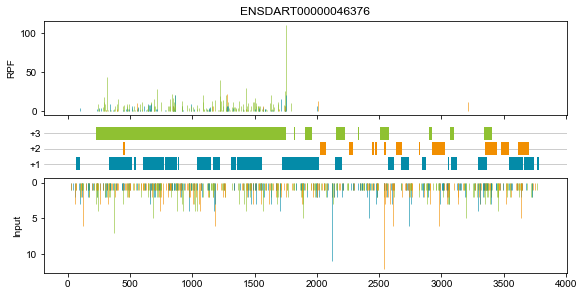

In [12]:
# Plot
fig = plt.figure(figsize=(8, 4), constrained_layout=True)

# Create axes
gs = fig.add_gridspec(ncols=1, nrows=3,  height_ratios=(2, 1, 2), hspace=0.01)
axr = fig.add_subplot(gs[0, 0])
axb = fig.add_subplot(gs[1, 0], sharex=axr)
axi = fig.add_subplot(gs[2, 0], sharex=axr)

# Axis look
axr.tick_params(axis='x', labelbottom=False)
axb.xaxis.set_visible(False)
axb.spines['top'].set_visible(False)
axb.spines['bottom'].set_visible(False)
axb.spines['left'].set_visible(False)
axb.spines['right'].set_visible(False)
axb.tick_params(axis='both', which='both', length=0)

# RPF
axr.vlines(np.arange(len(prpf)), ymin=0, ymax=prpf, colors=pcolors, linewidth=0.6)
# Input
axi.vlines(np.arange(len(pinput)), ymin=0, ymax=pinput, colors=pcolors, linewidth=0.6)
axi.invert_yaxis()

# ORF box
axb.set_yticks([(0.85/2.)+i for i in range(3)])
axb.set_yticklabels(['+1', '+2', '+3'])
for i in range(3):
    axb.axhline((0.85/2.)+i, color='#adadad', linewidth=0.6, zorder=1)

for iorf, orf in enumerate(orfs):
    axb.broken_barh([(o[0], o[1]-o[0]) for o in orf], (iorf, 0.85), facecolors=frame_colors[iorf], zorder=2)

# Labels
axr.set_title(transcript_id)
axr.set_ylabel('RPF')
axi.set_ylabel('Input')

**Figure legend**

* Open reading frames (ORFs) are represented by the colored boxed in the middle frame in the 3 frames (marked +1, +2 and +3)
* Positions on the transcript in frame with ORFs in the +1, +2 or +3 frame are colored using the same color as the ORF.
* The upper pannel shows ribosome profected fragment (RPF) and the lower mRNA-seq counts at the same time-point.

In this example, the main coding sequence (CDS) is in the +1 frame in blue and is highly translated as shown by the same color
blue RPF reads in the upper panel. By contrast, the mRNA-seq (Input) has no frame and shows the level of expression of the transcript.

In [13]:
# Save plot
if mpl.is_interactive() is False:
    fig.savefig(f'{transcript_id}{outext}')